
Target :
```
Introduce GAP at the n-1th layer following which 1x1 conv
```



Results:
    

```
Parameters: 12,248
Best Train Accuracy: 98.96 (18th Epoch)
Best Train Accuracy: 99.04 (16th Epoch)
```


Analysis:
   

```
GAP really fills the GAP between training and test acc. Power of 1x1 is not weakened its always intact whereever possibly it can be placed.
```

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


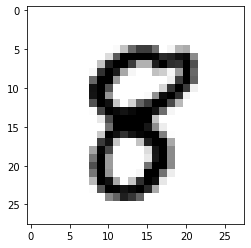

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# Look at the image, analyze how many convulations are needed just to figure out edges
plt.imshow(images[7].numpy().squeeze(), cmap='gray_r')
# Image below shows that at a RF of 5 or two conv we can easily found edges...

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

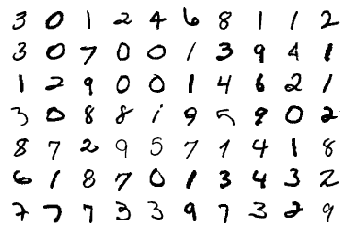

In [0]:
figure = plt.figure()
num_of_images = 70
for index in range(1, num_of_images + 1):
    plt.subplot(7, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
# Experiment-1 Reducing Parameters (set the model right). Impact: Parameters gone down/ no overfit/ low accuracy
# Experiment-2 Re-Structuring model looking at the receptive field. Impact: Parameters gone down further/ no overfit/ low accuracy
# Experiment-3 Adding BatchNorm to bump up the accuracy . Impact: limited parameters/ Overfitting/ accuracy improved
# Experiment-4 Adding Dropout to regularize. Impact: limited parameters/ no overfit/ test accuracy consistent
# Experiment-5 Restructuring model with GAP at the end of the convolutions
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout2d(0.25)
        ) #input:28x28 Output:26x26 RF:3x3
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.25)
        ) #input:26x26 Output:24x24 RF:5x5

          ######################### TRANSITION BLOCK 1 ############################
        self.pool1 = nn.MaxPool2d(2, 2) #input:24x24 Output:12x12 RF:6x6

        self.conv_1x1_1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            
        ) #input:13x13 Output:12x12 RF:6x6

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.25)
        ) #input:12x12 Output:10x10 RF:10x10

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.25)
        ) #input:10x10 Output:8x8 RF:14x14

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout2d(0.25)
        ) #input:10x10 Output:8x8 RF:18x18

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout2d(0.25)
        ) #input:8x8 Output:6x6 RF:22x22

         ######################### TRANSITION BLOCK 2 ############################
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) #input:6x6 Output:1x1 RF:32x32

        self.conv_1x1_2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1,1), padding=0, bias=False)
        )
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.conv_1x1_1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.conv_1x1_2(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
         Dropout2d-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.32076531648635864 Batch_id=468 Accuracy=73.35: 100%|██████████| 469/469 [00:11<00:00, 39.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1415, Accuracy: 9621/10000 (96.21%)

EPOCH: 1


Loss=0.3070633113384247 Batch_id=468 Accuracy=91.58: 100%|██████████| 469/469 [00:11<00:00, 39.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Accuracy: 9743/10000 (97.43%)

EPOCH: 2


Loss=0.16939549148082733 Batch_id=468 Accuracy=93.50: 100%|██████████| 469/469 [00:11<00:00, 40.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0652, Accuracy: 9792/10000 (97.92%)

EPOCH: 3


Loss=0.10037042945623398 Batch_id=468 Accuracy=94.40: 100%|██████████| 469/469 [00:11<00:00, 41.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0591, Accuracy: 9807/10000 (98.07%)

EPOCH: 4


Loss=0.3805070221424103 Batch_id=468 Accuracy=94.91: 100%|██████████| 469/469 [00:11<00:00, 40.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9830/10000 (98.30%)

EPOCH: 5


Loss=0.14410388469696045 Batch_id=468 Accuracy=95.23: 100%|██████████| 469/469 [00:11<00:00, 46.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9849/10000 (98.49%)

EPOCH: 6


Loss=0.33799242973327637 Batch_id=468 Accuracy=95.68: 100%|██████████| 469/469 [00:11<00:00, 41.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9853/10000 (98.53%)

EPOCH: 7


Loss=0.16168563067913055 Batch_id=468 Accuracy=95.81: 100%|██████████| 469/469 [00:11<00:00, 41.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9861/10000 (98.61%)

EPOCH: 8


Loss=0.1629103422164917 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:11<00:00, 41.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0387, Accuracy: 9871/10000 (98.71%)

EPOCH: 9


Loss=0.23567967116832733 Batch_id=468 Accuracy=96.00: 100%|██████████| 469/469 [00:11<00:00, 41.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9874/10000 (98.74%)

EPOCH: 10


Loss=0.10691525787115097 Batch_id=468 Accuracy=96.24: 100%|██████████| 469/469 [00:11<00:00, 49.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9882/10000 (98.82%)

EPOCH: 11


Loss=0.1678636521100998 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:11<00:00, 42.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9878/10000 (98.78%)

EPOCH: 12


Loss=0.21440596878528595 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:11<00:00, 41.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9890/10000 (98.90%)

EPOCH: 13


Loss=0.06027672067284584 Batch_id=468 Accuracy=96.46: 100%|██████████| 469/469 [00:11<00:00, 46.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Accuracy: 9895/10000 (98.95%)

EPOCH: 14


Loss=0.11047714948654175 Batch_id=468 Accuracy=96.61: 100%|██████████| 469/469 [00:11<00:00, 49.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9897/10000 (98.97%)

EPOCH: 15


Loss=0.05878737196326256 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:11<00:00, 42.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Accuracy: 9900/10000 (99.00%)

EPOCH: 16


Loss=0.10004118829965591 Batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:11<00:00, 42.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9885/10000 (98.85%)

EPOCH: 17


Loss=0.047349993139505386 Batch_id=468 Accuracy=96.70: 100%|██████████| 469/469 [00:11<00:00, 41.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9902/10000 (99.02%)

EPOCH: 18


Loss=0.14661915600299835 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:11<00:00, 41.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9904/10000 (99.04%)

EPOCH: 19


Loss=0.11937985569238663 Batch_id=468 Accuracy=96.86: 100%|██████████| 469/469 [00:11<00:00, 41.63it/s]



Test set: Average loss: 0.0305, Accuracy: 9893/10000 (98.93%)



Text(0.5, 1.0, 'Test Accuracy')

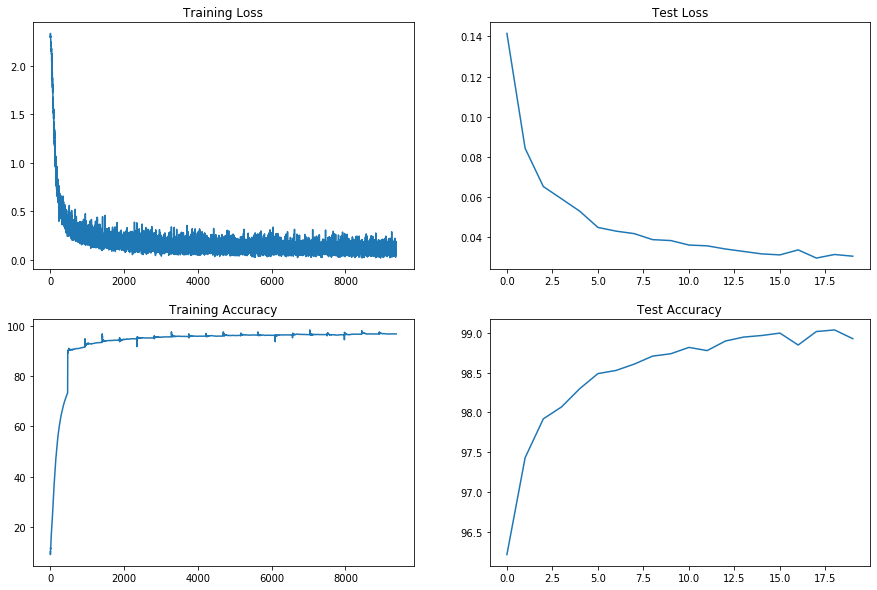

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")